In [ ]:
from src.modeling.clasification_models import * 
from src.modeling.ner import * 
from src.modeling.sentiment_analisis import * 
from src.modeling.sentimet_utils import * 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from src.embeddings.tf_idf import *
from src.embeddings.bow import *
from src.embeddings.embeddings import *



# Prediction Using AI Models

In this section, three different modeling approaches were implemented on the corpus:

1. **Thematic News Classification**  
   To assign each news article to the predefined categories, three baseline models were trained:

   - **Multilayer Perceptron (MLP)**: a neural network with two hidden layers (128 and 64 neurons), using the _ReLU_ activation function and the _Adam_ optimizer. It was evaluated with stratified validation, and performance was reported through _accuracy_, a classification report, and a confusion matrix.  
   - **SVM (Support Vector Machine)**: a linear variant (_LinearSVC_) was used, well-suited for TF-IDF and BoW representations, standing out for its speed and effectiveness in high-dimensional text.  
   - **Random Forest (RF)**: an ensemble of decision trees trained with 100 estimators in parallel, robust to noise and useful for interpreting feature importance.  

   In all cases, a **confusion matrix visualization** was included to evaluate errors by class, along with classification reports. This made it possible to identify not only the overall accuracy but also which categories were harder to separate (e.g., _society_culture_ vs _entertainment_).

2. **Sentiment Analysis**  
   To capture the affective load of the news articles, the pretrained model **`ignacio-ave/beto-sentiment-analysis-spanish`**, based on **BETO (BERT for Spanish)**, was employed.  
   This model assigns each text to five ordinal classes: _VERY NEGATIVE_, _NEGATIVE_, _NEUTRAL_, _POSITIVE_, _VERY POSITIVE_, and also includes an additional _UNDEFINED_ class for ambiguous cases.  
   Since the corpus consists of long-form news articles, a robust Spanish-adapted model was prioritized, allowing the extraction of polarity signals that can later be cross-referenced with categories or temporal trends.

3. **Named Entity Recognition (NER)**  
   To extract **people, organizations, places, and miscellaneous entities**, an interactive function was implemented to filter entities by thematic category and date.

   - The system groups entity mentions and allows visualization of the most frequent ones in interactive charts.  
   - A flexible approach with _widgets_ in Google Colab was employed, facilitating dynamic exploration of the corpus by political actors, institutions, or regions.  

   This stage complements the previous analyses, as it makes it possible to observe not only the polarity of the texts but also **which actors or institutions dominate the agenda** in each period.

With these three approaches (classification, sentiment, and NER), a comprehensive view of the corpus is achieved:

- **Classification**: organizes the news into main themes.  
- **Sentiment**: provides an affective layer to measure perceptions in discourse.  
- **NER**: identifies key actors and entities.  

Together, these methods transform a dispersed corpus into a **structured map of trends, emotions, and actors** in Colombian media.


---

## **1. Clasifictation**


In [ ]:
corpus_clean = pd.read_csv('data\\data_full\\Corpus_Raw.csv')
df = corpus_clean
X_nlp, v_word, v_char = fit_transform_embeddings(df, col="texto_tfidf")


cfg = BowConfig(ngram_range=(1, 2),     
        max_features=5000,      
        min_df=2,              
        max_df=0.95,            
        binary=False,          
        stop_words=None)

bow = BowFeaturizerDF(cfg)

bow.fit(df, text_col="texto_clean")
df_bow, X = bow.transform(df, text_col="texto_clean", out_col="bow", tolist=False)
print(df_bow.head())
print("Matriz BOW:", X.shape, "sparse?", sp.issparse(X))

df_bow2, X2 = bow.fit_transform_add_column(
        df, text_col="texto_clean", out_col="bow_list", tolist=True)
    
print(df_bow2.head())
print("Matriz BOW:", X2.shape)
bow.save_vectorizer("bow_vectorizer.joblib")
bow2 = BowFeaturizerDF()
bow2.load_vectorizer("bow_vectorizer.joblib")

df_bow_loaded, X_bow = bow2.transform(df, text_col="texto_clean", out_col="bow_loaded", tolist=False)



embedder = BertEmbedderDF(
        model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        pooling="mean",
        normalize=True,
        max_length=256)

df_emb, X_bert = embedder.add_embeddings_column(df,
        text_col="texto_clean",
        out_col="embedding",
        batch_size=32,
        return_matrix=True,   
        tolist=True )

print(df_emb.head())

print("Matriz:", X.shape) 



Iteration 1, loss = 1.84422990
Iteration 2, loss = 0.85070493
Iteration 3, loss = 0.43223529
Iteration 4, loss = 0.25918989
Iteration 5, loss = 0.19274972
Iteration 6, loss = 0.16413570
Iteration 7, loss = 0.15803386
Iteration 8, loss = 0.15105682
Iteration 9, loss = 0.14820955
Iteration 10, loss = 0.14159078
Iteration 11, loss = 0.14169471
Iteration 12, loss = 0.13966999
Iteration 13, loss = 0.13069862
Iteration 14, loss = 0.13680051
Iteration 15, loss = 0.12973502
Iteration 16, loss = 0.13516877
Iteration 17, loss = 0.12428892
Iteration 18, loss = 0.13130202
Iteration 19, loss = 0.12700538
Iteration 20, loss = 0.12377300


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



🔹 MLPClassifier
Accuracy: 0.7489975942261428

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.40      0.22      0.28        92
                 deportes       0.94      0.89      0.91       136
        economia_negocios       0.59      0.38      0.47        26
          entretenimiento       0.85      0.74      0.79        91
              estilo_vida       0.66      0.71      0.69       150
            internacional       0.76      0.80      0.78       163
        politica_gobierno       0.68      0.80      0.74       260
                 regiones       0.88      0.37      0.52        19
         sociedad_cultura       0.78      0.82      0.80       186
       tecnologia_ciencia       0.85      0.89      0.87       124

                 accuracy                           0.75      1247
                macro avg       0.74      0.66      0.68      1247
             weighted avg       0.74      0.75      0.

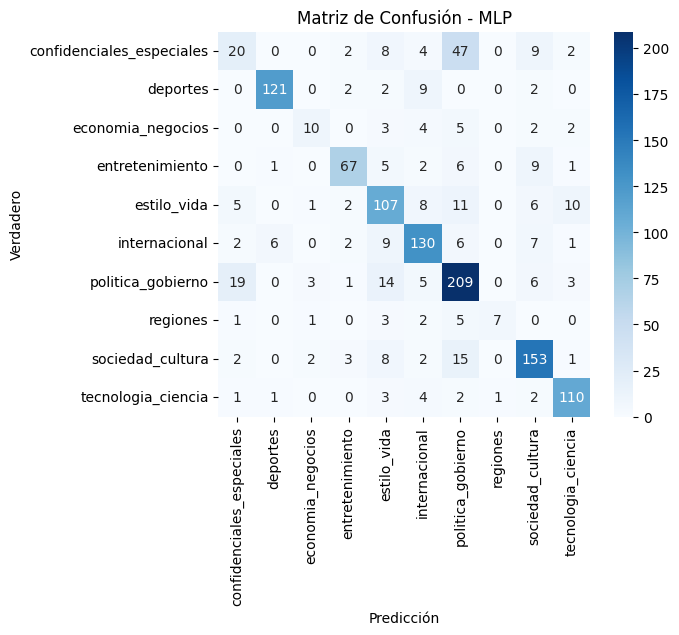

In [ ]:
y = df['categoria_grupo'].values

mlp_model = entrenar_mlp_randomsearch(X_nlp, y, max_iter=20)

### MLP Results

The **multilayer perceptron (MLP)** achieved an **overall accuracy of 74.9%**, showing competitive performance given the multiclass nature and the imbalance between categories.  
The class-level results highlight clear strengths and weaknesses:

- **Strengths**: categories such as _sports_ (F1 = 0.91), _technology_science_ (F1 = 0.87), and _society_culture_ (F1 = 0.80) display consistent classification, with high levels of _precision_ and _recall_.  
- **Intermediate performance**: broad classes like _politics_government_ (F1 = 0.74) and _international_ (F1 = 0.78) show acceptable balance, though with some confusion toward neighboring categories.  
- **Weaknesses**: underrepresented categories such as _economy_business_ (F1 = 0.47) and _regions_ (F1 = 0.52) exhibit low generalization capacity and high confusion with more frequent classes (_politics_government_ and _society_culture_).  

The **confusion matrix** confirms that the most common errors are concentrated in classes with lower representation, suggesting that the model is sensitive to the **corpus imbalance**. However, the behavior of the loss curve shows stable learning, although it did not fully converge within 20 iterations, leaving room for improvement with more epochs or regularization techniques.

In conclusion, the MLP proves to be an **effective model for thematic news classification**, reaching a solid overall performance, but limited in minority classes where data scarcity hinders precise discrimination.


---

## **SVM (Kernel Lineal)**


🔹 SVM
Accuracy: 0.7602245388933441

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.43      0.24      0.31        92
                 deportes       0.94      0.89      0.91       136
        economia_negocios       0.50      0.38      0.43        26
          entretenimiento       0.85      0.75      0.80        91
              estilo_vida       0.71      0.73      0.72       150
            internacional       0.79      0.81      0.80       163
        politica_gobierno       0.69      0.82      0.75       260
                 regiones       0.64      0.37      0.47        19
         sociedad_cultura       0.79      0.81      0.80       186
       tecnologia_ciencia       0.86      0.91      0.88       124

                 accuracy                           0.76      1247
                macro avg       0.72      0.67      0.69      1247
             weighted avg       0.75      0.76      0.75      12

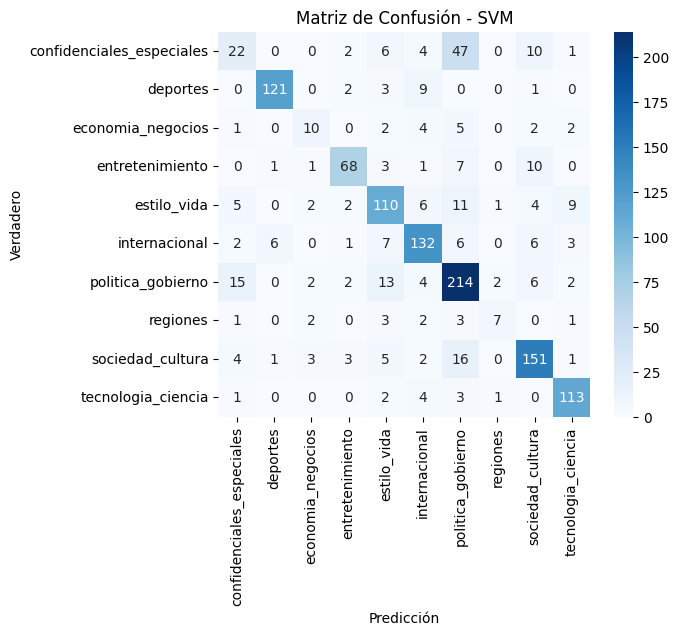

In [ ]:
svm_model = entrenar_svm_randomsearch(X_nlp, y)

---

### SVM Results

The **Support Vector Machine (SVM)** model achieved an **overall accuracy of 76.0%**, slightly outperforming the MLP in overall performance.

- **Strengths**: once again, categories such as _sports_ (F1 = 0.91), _technology_science_ (F1 = 0.88), _society_culture_ (F1 = 0.80), and _international_ (F1 = 0.80) stand out, where the model consistently captures patterns with high levels of _recall_.  
- **Intermediate performance**: _politics_government_ (F1 = 0.75) and _lifestyle_ (F1 = 0.72) show stable results, although the confusion matrix reveals some overlap with _society_culture_ and _international_.  
- **Weaknesses**: the smallest classes, such as _economy_business_ (F1 = 0.43) and _regions_ (F1 = 0.47), remain underrepresented and generate imprecise predictions, often being absorbed by dominant classes such as _politics_government_.  

Overall, the **SVM demonstrates greater robustness compared to the MLP**, especially in its ability to separate classes with more defined boundaries in high-dimensional spaces (TF-IDF). However, data imbalance still limits performance in minority categories, suggesting the need for additional techniques such as _oversampling_ (SMOTE) or _class weights_.  

In conclusion, the SVM proves to be a reliable classifier for this corpus, offering a solid balance between accuracy and generalization, while still leaving room for improvement in low-frequency classes.


---

## **Random Forest**


🔹 Random Forest
Accuracy: 0.7121090617481957

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.47      0.08      0.13        92
                 deportes       0.93      0.91      0.92       136
        economia_negocios       0.00      0.00      0.00        26
          entretenimiento       0.87      0.73      0.79        91
              estilo_vida       0.71      0.65      0.68       150
            internacional       0.72      0.65      0.68       163
        politica_gobierno       0.62      0.90      0.73       260
                 regiones       0.79      0.58      0.67        19
         sociedad_cultura       0.71      0.74      0.72       186
       tecnologia_ciencia       0.70      0.85      0.77       124

                 accuracy                           0.71      1247
                macro avg       0.65      0.61      0.61      1247
             weighted avg       0.70      0.71      0.

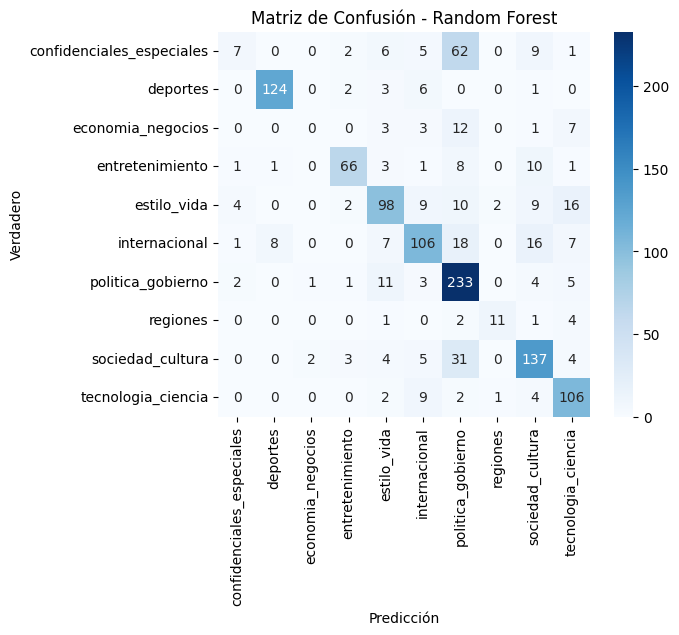

In [ ]:
rf_model  = entrenar_random_forest(X_nlp, y, n_estimators=200)

### Random Forest Results

The **Random Forest (RF)** model achieved an **overall accuracy of 71.2%**, making it the lowest-performing classifier among the three tested.

- **Strengths**: categories such as _sports_ (F1 = 0.92), _entertainment_ (F1 = 0.79), and _technology_science_ (F1 = 0.77) show solid results, with high _recall_ in sports and technology. Likewise, _politics_government_ exhibits a good level of _recall_ (0.90), albeit at the cost of lower _precision_, suggesting overgeneralization.  
- **Intermediate performance**: broad categories like _society_culture_ (F1 = 0.72) and _lifestyle_ (F1 = 0.68) maintain acceptable results, though with a wider dispersion of errors into other classes.  
- **Weaknesses**: the _economy_business_ class was not learned correctly (F1 = 0.00), and _special_reports_confidentials_ shows very poor performance (F1 = 0.13). This reveals that Random Forest struggles to capture patterns in small, imbalanced classes.

The confusion matrix confirms that errors are concentrated in minority classes, where the model tends to classify them into majority categories such as _politics_government_ or _society_culture_.

In short, although **Random Forest achieves reasonable performance in dominant categories**, its generalization capacity is lower compared to SVM and MLP, making it the least competitive model within this set of experiments.


### **Conclusions on Classification**

From the application of the three classification models, **SVM** achieved the best performance with an accuracy of **76%**, slightly outperforming **MLP** (75%) and **Random Forest** (71%). This superiority is also reflected in the **F1-scores**, where SVM shows a more consistent balance between _precision_ and _recall_ compared to the other models.

The analysis of the **confusion matrices** provides a more detailed understanding of each model’s behavior. An illustrative example is the case of **Random Forest**, where 31 news articles labeled as _society_culture_ were misclassified as _politics_government_. This confusion is reasonable, since both categories share thematic boundaries: a cultural story can have a political background, and a political story can contain cultural elements.

This finding highlights an inherent limitation of the process: **manual labeling of news**. Although it was carried out carefully, the subjective nature of the task can introduce inconsistencies that affect model performance. This opens up two important avenues for improvement:

1. **Label refinement**: through stricter protocols, annotator consensus, or even _active learning_ techniques in which the model informs the labeling process.  
2. **Unsupervised exploration**: applying _clustering_ techniques (e.g., K-Means or DBSCAN on vector representations such as TF-IDF or BERT embeddings) would allow us to assess how many thematic groups emerge naturally from the corpus. This would not only validate current labels but could also reveal new categories not initially considered.

In conclusion, the experiments show that supervised models achieve robust performance—especially SVM—but they also underscore the importance of combining **supervised and unsupervised** approaches to obtain a more accurate and representative classification of the corpus. In this way, the analysis is enriched by integrating both classical machine learning and exploratory strategies that help us better understand the news’ thematic structure.


---

## **Robustness and Comparison Using Different Embedding Implementations**


While **TF-IDF** was used as our primary embedding for the classification tasks (results presented earlier), to assess the system’s **robustness** and verify the consistency of the findings, we replicated the experiments—provided as an annex—using alternative representations: **Bag of Words (BoW)** and **semantic embeddings based on pretrained models (Sentence-BERT)**. This comparison makes it possible to analyze how different forms of textual representation affect classifier performance.


### **Modelos con BOW**:


Iteration 1, loss = 1.30119350
Iteration 2, loss = 0.60712248
Iteration 3, loss = 0.44936717
Iteration 4, loss = 0.36919082
Iteration 5, loss = 0.32613107
Iteration 6, loss = 0.28164978
Iteration 7, loss = 0.26220554
Iteration 8, loss = 0.22830997
Iteration 9, loss = 0.20794996
Iteration 10, loss = 0.19318180
Iteration 11, loss = 0.17634404
Iteration 12, loss = 0.16285447
Iteration 13, loss = 0.15395393
Iteration 14, loss = 0.15091782
Iteration 15, loss = 0.14602375
Iteration 16, loss = 0.14399726
Iteration 17, loss = 0.13829407
Iteration 18, loss = 0.13574344
Iteration 19, loss = 0.12746955
Iteration 20, loss = 0.13025251
🔹 MLPClassifier
Accuracy: 0.7225340817963112

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.33      0.23      0.27        92
                 deportes       0.93      0.89      0.91       136
        economia_negocios       0.38      0.38      0.38        26
          entretenimiento  

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



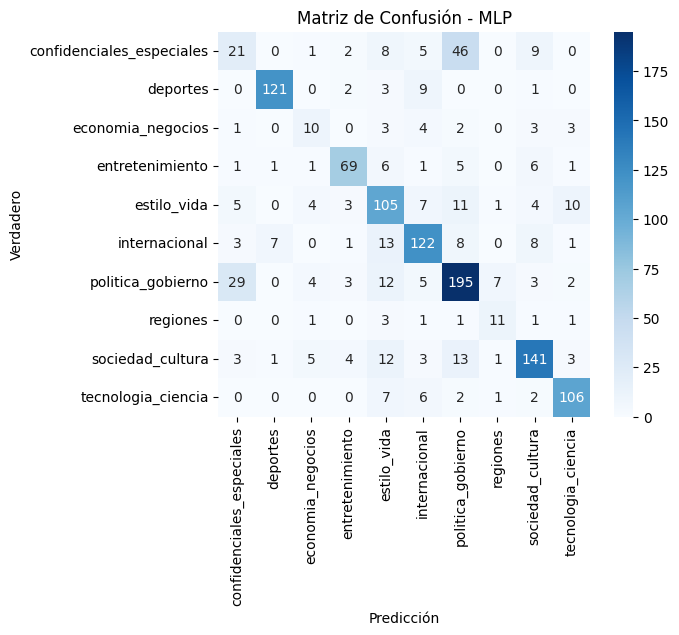

In [ ]:
mlp_model2 = entrenar_mlp(X_bow, y, max_iter=20)

### Results with BoW – MLP

Using **Bag of Words (BoW)** to represent the texts and a **Multilayer Perceptron (MLP)** as the classifier yielded an **overall accuracy of 72%**, which is acceptable performance, albeit lower than what was achieved with TF-IDF.

The confusion matrix shows consistent behavior in categories such as **sports** and **technology_science**, where the model attains high precision and recall. However, there are greater difficulties in categories like **special_reports_confidentials** and **economy_business**, where thematic dispersion and the smaller volume of examples hinder the model’s ability to generalize.

Overall, the results suggest that while BoW provides a functional approach, its limited capacity to capture semantic relationships between terms constrains performance compared to TF-IDF or more sophisticated embeddings.


---


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



🔹 SVM
Accuracy: 0.6784282277465918

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.29      0.20      0.23        92
                 deportes       0.91      0.87      0.89       136
        economia_negocios       0.33      0.31      0.32        26
          entretenimiento       0.76      0.76      0.76        91
              estilo_vida       0.59      0.64      0.62       150
            internacional       0.76      0.73      0.74       163
        politica_gobierno       0.67      0.68      0.67       260
                 regiones       0.52      0.74      0.61        19
         sociedad_cultura       0.67      0.69      0.68       186
       tecnologia_ciencia       0.71      0.80      0.75       124

                 accuracy                           0.68      1247
                macro avg       0.62      0.64      0.63      1247
             weighted avg       0.67      0.68      0.67      12

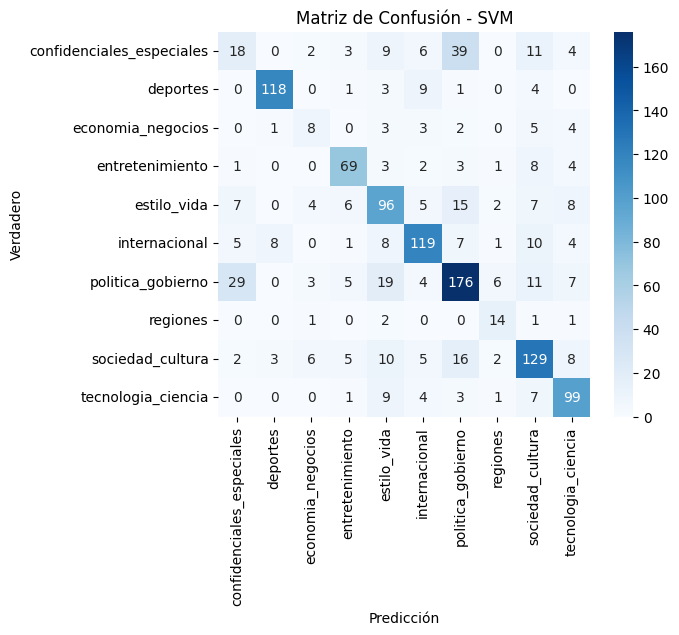

In [ ]:
svm_model2 = entrenar_svm_randomsearch(X_bow, y, kernel="linear")

### Results with BoW – SVM

Using **Bag of Words (BoW)** as the embedding and a **linear SVM** model for classification yielded an **accuracy of 68%**, the lowest performance among the models tested under this setup.

The confusion matrix shows that the model performs relatively well in categories such as **sports**, **international**, and **technology_science**, but exhibits weaknesses in smaller, more heterogeneous classes like **special_reports_confidentials** and **economy_business**, where confusion with higher-volume labels—especially **politics_government**—is frequent.

This outcome highlights one of BoW’s limitations: its inability to capture more complex semantic relationships between words, which affects the classifier’s capacity in contexts where terms overlap across categories. Even so, the results are consistent with the notion that SVM tends to generalize well in high-dimensional spaces, although it does not surpass TF-IDF in this case.


🔹 Random Forest
Accuracy: 0.7209302325581395

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.44      0.08      0.13        92
                 deportes       0.93      0.90      0.92       136
        economia_negocios       0.25      0.08      0.12        26
          entretenimiento       0.85      0.74      0.79        91
              estilo_vida       0.69      0.69      0.69       150
            internacional       0.75      0.72      0.74       163
        politica_gobierno       0.63      0.86      0.73       260
                 regiones       0.75      0.47      0.58        19
         sociedad_cultura       0.75      0.73      0.74       186
       tecnologia_ciencia       0.70      0.89      0.78       124

                 accuracy                           0.72      1247
                macro avg       0.67      0.62      0.62      1247
             weighted avg       0.71      0.72      0.

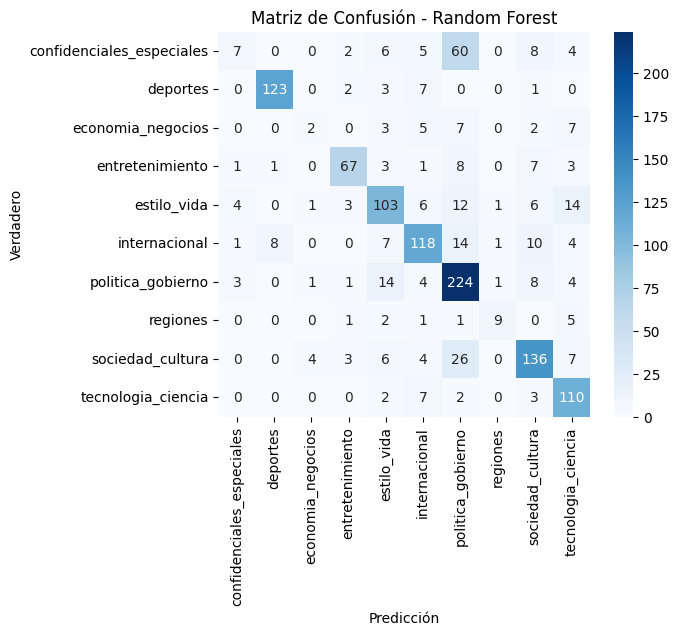

In [ ]:
rf_model2  = entrenar_rf_randomsearch(X_bow, y)

### Results with BoW – Random Forest

Applying **Random Forest** on **Bag of Words (BoW)** embeddings achieved an **accuracy of 72%**, placing it in an intermediate range compared to MLP and SVM under the same setup.

The confusion matrix shows that the model consistently classifies categories such as **sports**, **technology_science**, and **politics_government**, but exhibits a notable drop in less represented classes like **economy_business** or **special_reports_confidentials**, where both precision and recall are low. This reflects the algorithm’s difficulty in generalizing for categories with few examples or fuzzy boundaries relative to others.

Overall, the results indicate that Random Forest benefits from BoW’s robustness at capturing frequent patterns, but it remains more sensitive to the imbalanced class distribution, which limits its overall performance compared to richer representations like TF-IDF or semantic embeddings.

### Conclusion on Bag of Words (BoW)

Using **BoW** made it possible to validate the pipeline’s robustness when compared to TF-IDF. While the results were acceptable (with accuracies around 70%), this approach has limitations in adequately capturing the semantic context of words. This leads to confusions in categories with fuzzy boundaries, although it remains useful as a baseline to contrast with more sophisticated representations such as TF-IDF or transformer-based embeddings.


### **Modelos con Embeddings tipo BERT**:


Iteration 1, loss = 1.79960275
Iteration 2, loss = 1.35687084
Iteration 3, loss = 1.22497150
Iteration 4, loss = 1.15123126
Iteration 5, loss = 1.09764717
Iteration 6, loss = 1.05391607
Iteration 7, loss = 1.03551424
Iteration 8, loss = 0.99991122
Iteration 9, loss = 0.97194293
Iteration 10, loss = 0.94275893
Iteration 11, loss = 0.90928736
Iteration 12, loss = 0.89897273
Iteration 13, loss = 0.88530877
Iteration 14, loss = 0.87767109
Iteration 15, loss = 0.83076731
Iteration 16, loss = 0.81779064
Iteration 17, loss = 0.78788896
Iteration 18, loss = 0.77084583
Iteration 19, loss = 0.76196742
Iteration 20, loss = 0.76046477
🔹 MLPClassifier
Accuracy: 0.6704089815557338

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.39      0.24      0.30        92
                 deportes       0.86      0.79      0.82       136
        economia_negocios       0.25      0.08      0.12        26
          entretenimiento  

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.



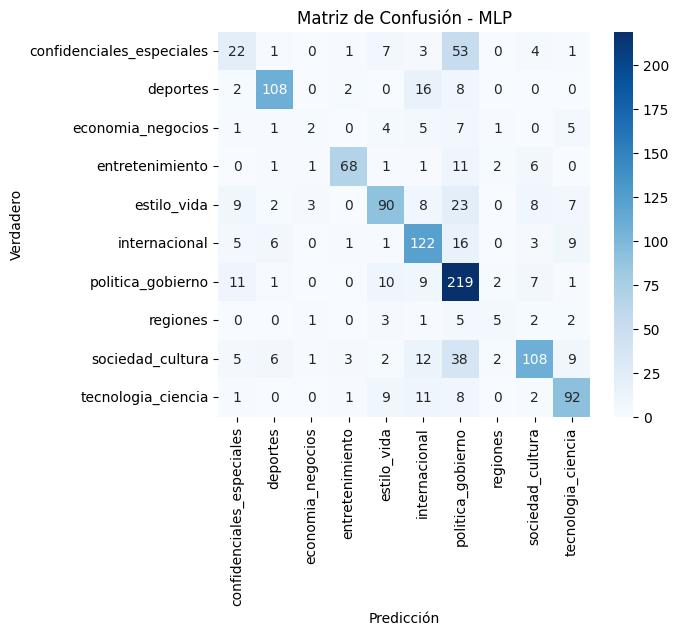

In [ ]:
mlp_model3 = entrenar_mlp_randomsearch(X_bert, y, max_iter=20)

### Results with BERT – MLP

The **MLP on BERT embeddings** achieved an **overall accuracy of 67%**, a lower performance compared to the TF-IDF and BoW experiments. Although BERT’s semantic representations generally capture richer contextual information, in this case the model struggled to generalize stably—especially in underrepresented categories such as **economy_business** or **regions**, where performance was clearly low.

The confusion matrix shows that categories with a larger number of examples—such as **politics_government** or **international**—maintain relatively solid performance, whereas minority classes tend to be confused with broader, thematically close categories.

This suggests that, while BERT provides more informative embeddings, pairing it with a simple classifier like MLP may not be sufficient to fully exploit its potential. Future work could explore fine-tuning the base model or using more sophisticated classifiers that better adapt to the nature of contextual embeddings.


🔹 SVM
Accuracy: 0.6343223736968725

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.27      0.20      0.23        92
                 deportes       0.87      0.79      0.83       136
        economia_negocios       0.24      0.23      0.24        26
          entretenimiento       0.73      0.74      0.73        91
              estilo_vida       0.58      0.62      0.60       150
            internacional       0.63      0.60      0.61       163
        politica_gobierno       0.62      0.68      0.65       260
                 regiones       0.25      0.21      0.23        19
         sociedad_cultura       0.67      0.68      0.68       186
       tecnologia_ciencia       0.69      0.76      0.72       124

                 accuracy                           0.63      1247
                macro avg       0.56      0.55      0.55      1247
             weighted avg       0.63      0.63      0.63      12

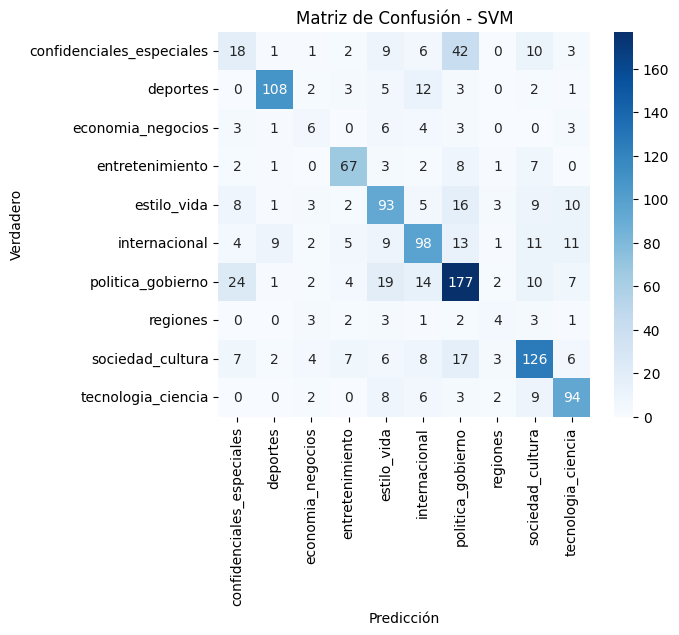

In [ ]:
svm_model3 = entrenar_svm_randomsearch(X_bert, y)

### Results with BERT – SVM

The combination of **SVM with BERT embeddings** achieved an **accuracy of 63%**, the lowest performance among the variants tested. Although SVM tends to work well with linear representations like TF-IDF or BoW, in this case it appears to struggle to leverage the contextual richness of BERT embeddings.

The confusion matrix shows that categories with many examples, such as **politics_government** or **society_culture**, maintain acceptable performance, whereas underrepresented classes (**economy_business**, **regions**) perform very poorly. This indicates that the model does not correctly separate the boundaries between semantically close classes and tends to confuse categories with overlapping thematic content.

In conclusion, while BERT embeddings offer an advanced representation, using them directly with SVM is not optimal. It would be advisable to consider techniques such as **fine-tuning the base model** or more complex classifiers (e.g., deep neural networks) that can better exploit the embeddings’ non-linear structure.









🔹 Random Forest
Accuracy: 0.6110665597433841

Reporte de clasificación:
                            precision    recall  f1-score   support

confidenciales_especiales       0.00      0.00      0.00        92
                 deportes       0.90      0.74      0.81       136
        economia_negocios       0.33      0.04      0.07        26
          entretenimiento       0.86      0.69      0.77        91
              estilo_vida       0.52      0.57      0.54       150
            internacional       0.58      0.58      0.58       163
        politica_gobierno       0.50      0.83      0.63       260
                 regiones       0.50      0.05      0.10        19
         sociedad_cultura       0.67      0.61      0.64       186
       tecnologia_ciencia       0.68      0.72      0.70       124

                 accuracy                           0.61      1247
                macro avg       0.56      0.48      0.48      1247
             weighted avg       0.59      0.61      0.

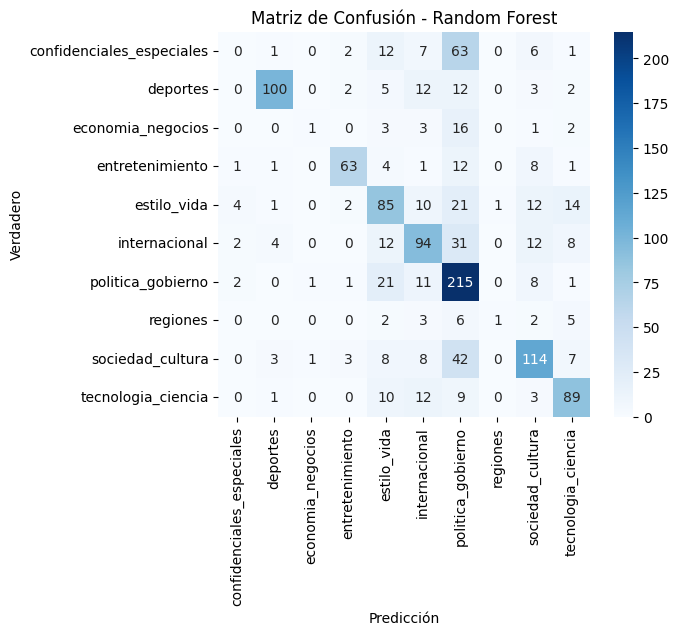

In [ ]:
rf_model3  = entrenar_rf_randomsearch(X_bert, y, n_estimators=200)

### Results with BERT – Random Forest

The **Random Forest with BERT embeddings** model achieved an **accuracy of 61%**, the lowest performance among the evaluated combinations. The confusion matrix shows that several categories were particularly problematic, such as **special_reports_confidentials** (with virtually no correct predictions) and **economy_business**, which reported a very low F1-score.

Although more frequent categories like **politics_government** or **society_culture** performed reasonably well, the model tends to overfit to these dominant classes and to confuse those with lower representation. This highlights the **limitation of Random Forest in capturing deep semantic relationships** when using dense embeddings such as BERT, since this type of representation does not align well with tree-based partitioning.

In conclusion, the results suggest that using Random Forest on BERT embeddings is not an adequate strategy, and it would be preferable to opt for models more aligned with distributed representations, such as deep neural networks or task-specific fine-tuning techniques.


---

### Conclusions on BERT Embeddings

When applying BERT embeddings as text representations, the results show **lower performance** compared to TF-IDF and Bag of Words. Specifically, models trained with BERT embeddings reached accuracy levels between **61% and 67%**, well below the 76% achieved with TF-IDF. Moreover, the confusion matrices reveal greater overlap among thematically close categories (for example, _society_culture_ with _politics_government_ or _international_), indicating that the model does not clearly separate the semantic boundaries of each class.

A plausible explanation is that the **reduced size of the corpus (≈6,500 news articles)** limits BERT embeddings’ ability to generalize properly. These dense representations usually require **large data volumes** to shine and to demonstrate an advantage over traditional methods. In smaller data contexts, BERT’s semantic richness does not necessarily translate into better performance, as classifiers may overfit or fail to fully leverage the embeddings’ dimensionality.

In conclusion, while BERT provides richer semantic information, in this project its results are constrained by the dataset size. With a larger and more balanced corpus, it is reasonable to expect BERT embeddings to outperform TF-IDF and BoW in news classification tasks.

## **Final Conclusions on Classification**

From the application of the three representation schemes (TF-IDF, Bag of Words, and BERT) and their evaluation with classic classification models (MLP, SVM, and Random Forest), several key conclusions emerge:

1. **TF-IDF was the most robust representation.** With this embedding, the best results were achieved, particularly with **SVM (76% accuracy)**, slightly surpassing MLP (75%) and showing a more marked difference against Random Forest (71%). This indicates that, for a moderately sized corpus, sparse frequency-based representations remain highly effective for thematic classification tasks.

2. **Bag of Words delivered intermediate performance.** While results were reasonable (≈68–72% accuracy), in all cases they fell below TF-IDF. This suggests that, by not weighting relevant terms, BoW loses discriminative power compared to TF-IDF.

3. **BERT did not outperform traditional methods.** Despite capturing richer semantic information, models trained with dense BERT embeddings achieved accuracies between **61% and 67%**, with clear difficulties in distinguishing close categories. This reinforces the hypothesis that the **relatively small dataset (≈6,500 news articles)** limits BERT’s true potential, which requires larger volumes of data to demonstrate an advantage over classical representations.

4. **Confusion among close classes.** Across all implementations, frequent errors occurred in categories with high thematic proximity, such as _society_culture_ with _politics_government_ or _international_. This may stem both from the inherent ambiguity of the news and from the manual labeling process, opening the door to improvements in annotation or the exploration of unsupervised approaches (clustering) to validate class coherence.

In summary, **TF-IDF + SVM emerges as the best combination** for this corpus, while BERT—though promising—requires a larger and more balanced dataset to reach its full potential. These results highlight the importance of adapting both the embedding choice and the classifier to the characteristics of the available dataset.


---

## 2. **Sentiment Analisis**


#### Sentiment Analysis Methodology (BETO model – 5+1 classes)

To classify sentiment in long texts, such as news articles, we used the Spanish checkpoint  
**`ignacio-ave/beto-sentiment-analysis-spanish`**, based on **BETO** (BERT trained for Spanish) and **fine-tuned for sentiment analysis**.  
This model produces **ordinal polarity classes**:

- **VERY NEGATIVE**, **NEGATIVE**, **NEUTRAL**, **POSITIVE**, **VERY POSITIVE**
- and a fallback class **UNDEFINED** when the text does not fit the above.

**Advantages of the pretrained approach.** We do not need to build embeddings manually: the model performs **subword tokenization** and generates **contextual representations** internally, offering better accuracy than bag-of-words approaches or static embeddings.

**Long texts (512-token limit).** To avoid losing information in long articles, we use a **sliding window** strategy: we split each document into **chunks of up to 512 tokens** with **overlap** (**stride**). Each chunk is processed in **batches** with **dynamic padding** on the GPU. To combine predictions for a single document, we **average the logits** of all its chunks and then apply softmax, obtaining a per-class probability for the entire document. This aggregation is **more stable** than averaging probabilities directly.

**Output and DataFrame columns.** For each article we include:

1. `sentimiento_5clases`: ordinal label in {VERY NEGATIVE, NEGATIVE, NEUTRAL, POSITIVE, VERY POSITIVE} (or **UNDEFINED** when applicable).
2. `score_5clases`: probability assigned by the model to the chosen class (after chunk-level aggregation).

**Implementation details.** We use the **model and tokenizer from the same repo** to avoid misalignment, run **on GPU** with batching and **dynamic padding**, and control the overlap (**stride**) to balance contextual coverage and computational efficiency. This configuration prioritizes **reproducible robustness** and **scalability** for news corpora.


In [ ]:

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
corpus = corpus_clean
corpus.head()

,Unnamed: 0,fecha,titulo,cuerpo,url,categoria,categoria_grupo,texto_tfidf
0,580,2025-08-26 13:31:46-05:00,YouTube hizo inesperado movimiento con intelig...,La plataforma de entretenimiento YouTube cuent...,https://www.semana.com//tecnologia/articulo/yo...,tecnologia,tecnologia_ciencia,plataforma entretenimiento youtube contar mill...
1,581,2025-08-26 16:39:02-05:00,Apple reveló la fecha de lanzamiento del iPhon...,Apple celebrará un nuevo evento de presentació...,https://www.semana.com//tecnologia/articulo/ap...,tecnologia,tecnologia_ciencia,apple celebrar evento presentacion producto se...
2,582,2025-08-21 19:13:31-05:00,La estrella más lejana conocida puede no serlo...,"Eärendel, un objeto descubierto en 2022 con el...",https://www.semana.com//tecnologia/articulo/la...,tecnologia,tecnologia_ciencia,rendel objeto descubierto telescopio espacial ...
3,583,2025-08-08 20:07:54-05:00,Por primera vez en la historia: investigadores...,Un equipo de especialistas en ciberseguridad r...,https://www.semana.com//tecnologia/articulo/po...,tecnologia,tecnologia_ciencia,equipo especialista ciberseguridad revelo meto...
4,584,2025-08-28 14:57:58-05:00,No solo es la inteligencia artificial: esta es...,"Para muchos ha resultado sorprendente cómo, en...",https://www.semana.com//tecnologia/articulo/no...,tecnologia,tecnologia_ciencia,resultar sorprendente ano inteligencia artific...


In [ ]:
cfg = InferenceConfig(
    model_name="ignacio-ave/beto-sentiment-analysis-spanish",
    text_col="texto_tfidf",
    out_label_col="sentimiento",
    out_score_col="score",
    batch_size=32,
    max_length=512,
    stride=128,
    add_proba_cols=True,)

corpus_out = predict_dataframe(corpus, cfg)
corpus_out.head()

In [ ]:
corpus_out.head()

,Unnamed: 0,fecha,titulo,cuerpo,url,categoria,categoria_grupo,texto_tfidf,sentimiento,score
0,580,2025-08-26 13:31:46-05:00,YouTube hizo inesperado movimiento con intelig...,La plataforma de entretenimiento YouTube cuent...,https://www.semana.com//tecnologia/articulo/yo...,tecnologia,tecnologia_ciencia,plataforma entretenimiento youtube contar mill...,VERY POSITIVE,0.489073
1,581,2025-08-26 16:39:02-05:00,Apple reveló la fecha de lanzamiento del iPhon...,Apple celebrará un nuevo evento de presentació...,https://www.semana.com//tecnologia/articulo/ap...,tecnologia,tecnologia_ciencia,apple celebrar evento presentacion producto se...,POSITIVE,0.856817
2,582,2025-08-21 19:13:31-05:00,La estrella más lejana conocida puede no serlo...,"Eärendel, un objeto descubierto en 2022 con el...",https://www.semana.com//tecnologia/articulo/la...,tecnologia,tecnologia_ciencia,rendel objeto descubierto telescopio espacial ...,NEGATIVE,0.602729
3,583,2025-08-08 20:07:54-05:00,Por primera vez en la historia: investigadores...,Un equipo de especialistas en ciberseguridad r...,https://www.semana.com//tecnologia/articulo/po...,tecnologia,tecnologia_ciencia,equipo especialista ciberseguridad revelo meto...,VERY NEGATIVE,0.715093
4,584,2025-08-28 14:57:58-05:00,No solo es la inteligencia artificial: esta es...,"Para muchos ha resultado sorprendente cómo, en...",https://www.semana.com//tecnologia/articulo/no...,tecnologia,tecnologia_ciencia,resultar sorprendente ano inteligencia artific...,VERY POSITIVE,0.640022


---

### **Analysis of Classified Sentiments**

Since **we do not have real sentiment labels in our corpus**, it is not possible to compute traditional performance metrics such as _accuracy_, _precision_, or _recall_. For this reason, the focus is on **analyzing the distribution and consistency of the model’s outputs**. In this way, we aim to identify relevant patterns, such as:

- **Sentiment distribution** within the corpus.  
- **Confidence scores** by class.  
- **Temporal evolution** of sentiment (moving average).  
- **Top trigrams** by polarity.  

This analysis provides **a qualitative approximation of the emotional bias present in the news**, assessing general trends without the need for a labeled reference set. Furthermore, it serves as a starting point for future extensions, such as the creation of a manually annotated dataset that would allow for a quantitative evaluation of the model’s performance.



---

### **Sentiment Distribution in the Corpus**


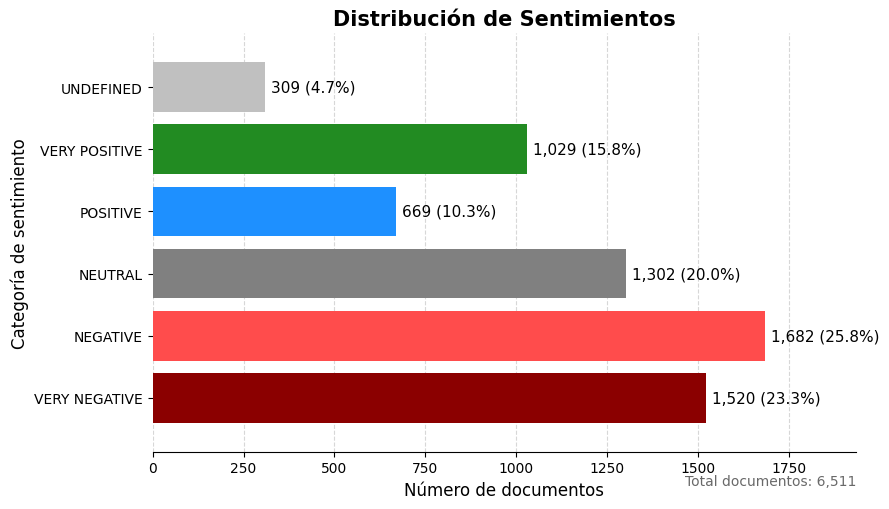

In [ ]:

fig, ax = plot_sentiment_bars(corpus_out)
plt.show()

#### Preliminary Interpretation of Sentiment Distribution

Most of the analyzed documents exhibit a **negative orientation**:

- **NEGATIVE (25.8%)** and **VERY NEGATIVE (23.3%)** together account for nearly **half of all observations**.  
- In contrast, documents with a **positive** evaluation (POSITIVE + VERY POSITIVE) only represent **26.1%**.  
- The **NEUTRAL (20%)** segment also carries significant weight, reflecting a considerable proportion of texts without a clear polarity.  
- Finally, **4.7%** of the cases were classified as **UNDEFINED**, likely associated with ambiguous texts or those with low emotional content.  

Overall, this distribution suggests that the news corpus tends to emphasize **negative aspects** more than positive ones, although there is also a non-negligible fraction of neutral and positive content.



---

### **Scores (confidence) per class.**


/tmp/ipython-input-2008984381.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




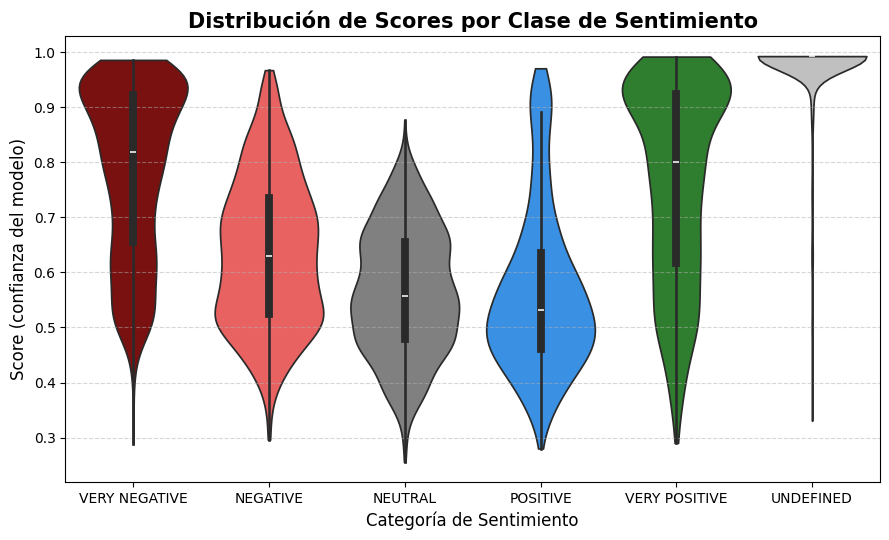

In [ ]:
fig, ax = plot_sentiment_violin(corpus_out)
plt.show()

#### Interpretation of the Violin Plot of Scores

The chart shows how the model’s **confidence** (`score`) varies for each sentiment class:

1. **Extreme classes (VERY NEGATIVE and VERY POSITIVE)**

   - Distributions are highly concentrated at high values (≈0.9–1.0).
   - This indicates that when the model assigns a very strong polarity, it does so with high certainty.
   - The median is clearly high, with relatively low dispersion.

2. **Intermediate classes (NEGATIVE and POSITIVE)**

   - Scores are more dispersed (≈0.4–0.8).
   - The model recognizes these categories, but with less confidence than for the extremes.
   - This reflects that some texts near the positive/negative boundary are assigned with uncertainty.

3. **NEUTRAL class**

   - The distribution is centered at mid-range values (≈0.5–0.7).
   - Confirms that the model tends to be **less categorical** with neutral news, which is consistent with the inherently ambiguous nature of this sentiment.
   - It is the class with the greatest variability in confidence.

4. **UNDEFINED class**
   - Notably, its scores appear in the highest range (≈0.9–1.0).
   - This suggests the model is **very confident when detecting non-classifiable cases**, likely because the text lacks clear affective signals.
   - In practice, it is worth reviewing how to handle this category (exclude it, or treat it as “undefined”).

The model shows a consistent pattern:

- **High certainty at the extremes** (very negative / very positive).
- **Moderate confidence in intermediate classes** (negative / positive).
- **Less-defined neutrality**, with greater score dispersion.
- **Undefined** operates as a “confident” class that nevertheless represents semantic ambiguity.



---

### **Temporal Evolution (media móvil).**


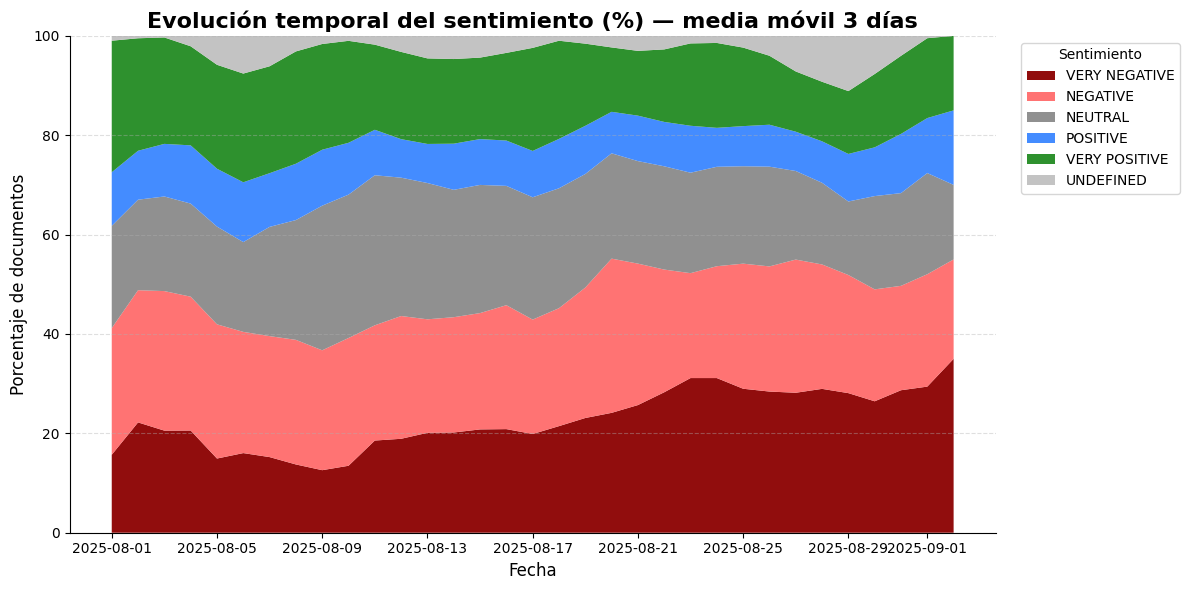

In [ ]:
fig, ax = plot_sentiment_stack(corpus_out)
plt.show()

- **Upward trend in negativity**: halfway through the month, the combined weight of _VERY NEGATIVE_ + _NEGATIVE_ increases and closes with its **relative peak** (≈55% of the total).  
- **Decline of neutrality**: the _NEUTRAL_ segment loses share as the month progresses, suggesting that coverage becomes more polarized.  
- **Limited and stable positivity**: _POSITIVE_ remains within a narrow band, while _VERY POSITIVE_ declines toward the end, contributing little to the total.  
- **Visual robustness**: the 3-day smoothing attenuates isolated spikes; the negative pattern does not depend on daily outliers.  
- **Methodological caution**: scraping was **more intensive toward the end of the month**, so the increase in negativity may be **amplified** by this temporal bias.  


---

### **Top trigramas por polaridad**


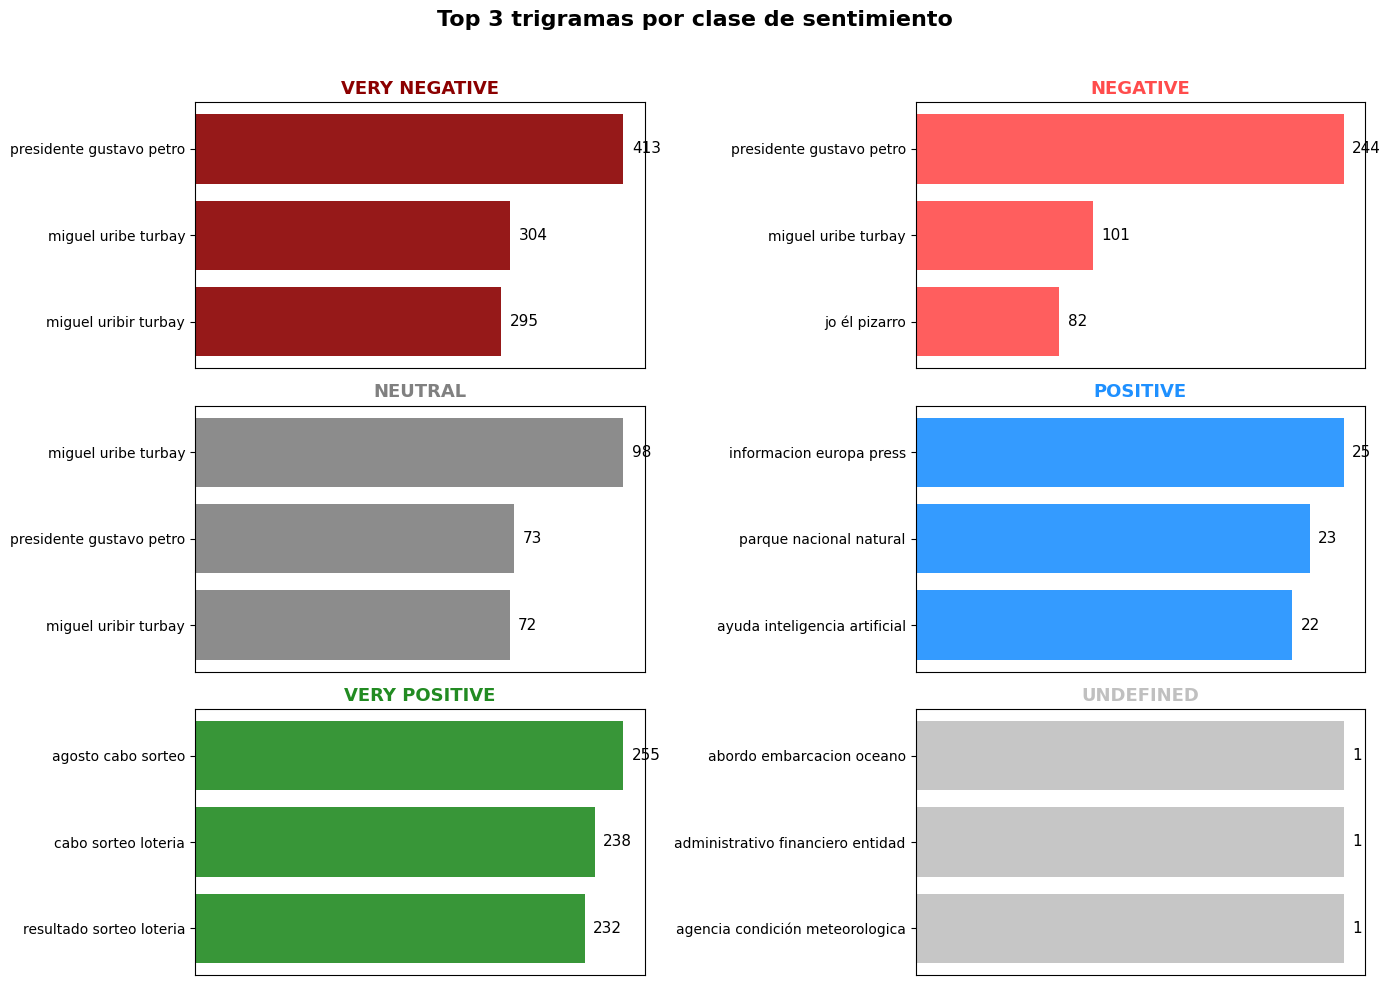

In [ ]:
top_ngrams(corpus_out)

#### Interpretation of Trigrams by Sentiment

1. **VERY NEGATIVE (Dark Red)**

   - Trigrams like _“presidente gustavo petro”_ and _“miguel uribe turbay”_ predominate.
   - This indicates that the highly negative narrative is strongly linked to **political criticism**, with an emphasis on high-profile figures.
   - It suggests a polarized and confrontational discourse.
   - It also mentions the death of the pre-candidate Miguel Uribe.

2. **NEGATIVE (Light Red)**

   - _“presidente gustavo petro”_ and _“miguel uribe turbay”_ stand out again, but _“jo él pizarro”_ also appears.
   - This reflects the spread of negative sentiment toward other political actors.
   - It reaffirms that the core of negativity is the **national political debate**.

3. **NEUTRAL (Gray)**

   - The most frequent trigrams remain _“miguel uribe turbay”_ and _“presidente gustavo petro”_.
   - The difference here is that the names appear in a more **descriptive/informational** tone rather than a critical one.
   - Neutral sentiment serves to report facts without strong emotional charge.

4. **POSITIVE (Blue)**

   - _“informacion europa press”_, _“parque nacional natural”_, and _“ayuda inteligencia artificial”_ stand out.
   - This group reflects a positive sentiment oriented toward **technological, environmental, and international** topics.
   - It shows a clear contrast with the political predominance in the negative classes.

5. **VERY POSITIVE (Green)**

   - Trigrams such as _“agosto cabo sorteo”_, _“cabo sorteo loteria”_, and _“resultado sorteo loteria”_ appear.
   - The very positive tone is mainly linked to **lottery or prize events**.
   - It reflects a narrative of celebration and favorable expectations.

6. **UNDEFINED (Light Gray)**
   - The trigrams (_“abordo embarcacion oceano”_, _“administrativo financiero entidad”_, _“agencia condición meteorologica”_) appear only once.
   - This indicates that this category is marginal and lacks clear representative patterns.

### **Conclusions from the Sentiment Analysis**

The sentiment analysis reveals that the predominant tone of the corpus is **negative**, with a significant presence of news classified as _VERY NEGATIVE_ and _NEGATIVE_. This is observed both in the **overall category distribution** and in the **temporal evolution**, where the proportions of negativity remain stable over time, even showing growth toward the end of the analyzed period. Neutrality occupies an important middle ground, while positive sentiments, though present, carry much less weight.

The **distribution of scores by sentiment class** shows that the extreme classes (_VERY NEGATIVE_ and _VERY POSITIVE_) are those in which the model exhibits higher confidence, reinforcing the robustness of classification at the ends of the spectrum. In contrast, the intermediate classes (_NEGATIVE, NEUTRAL, and POSITIVE_) display greater dispersion in confidence values, indicating that the model encounters more ambiguity when distinguishing between nearby tones.

Finally, the **trigram analysis by sentiment class** adds a qualitative layer: in the negative categories, mentions of political figures like _“presidente Gustavo Petro”_ and _“Miguel Uribe Turbay”_ recur, suggesting a bias toward political polarization in negative news. By contrast, positive trigrams concentrate on topics of a more informational or neutral nature, such as _“información Europa Press”_ or _“parque nacional natural.”_ The _VERY POSITIVE_ class is mainly associated with lotteries and raffles, indicating that positivity in the corpus does not stem from political or social matters, but from lighter, entertainment-oriented news.

Taken together, the results show that the corpus has a strong bias toward negativity, especially around political actors, whereas positive aspects tend to come from news of lesser structural relevance. This finding is key to understanding how the media tend to frame public discourse.



---

## 3. **NER analysis**


In [ ]:
interactive_ner_plot(corpus)

### **Named Entity Recognition (NER) Analysis**

The NER model automatically identifies relevant entities within the corpus, classifying them into categories such as **PER (people), ORG (organizations), LOC (locations), and MISC (other relevant terms)**. The visualization is **interactive**, making it easy to filter dynamically by thematic category (e.g., _politics_government_) or by date, adapting the analysis to different periods and contexts.

In the chart, within the _politics_government_ category, the names of political figures such as **“Petro”**, **“Gustavo Petro”**, **“Miguel Uribe Turbay”**, and **“Nicolás Maduro”** appear as the most frequent in the **PER** class. As for organizations (**ORG**), **“Fiscalía General de la Nación”**, **“Fuerzas Militares”**, **“Centro Democrático”**, and **“FARC”** stand out, reflecting the institutional and political relevance of these actors in the analyzed news. In **LOC**, there is a predominance of **“Colombia”**, along with mentions of **the United States**, **Bogotá**, **Medellín**, and **Venezuela**, suggesting an interplay between national and international dynamics. Finally, under **MISC**, terms such as **“Pacto Histórico”** and **“Presidencia”** appear, reflecting both political parties and expressions of media discourse.

The tool’s **interactivity** allows for detailed exploration of which entities are most relevant by topic and how these change over time, making it a valuable resource for investigating media narratives and tracking key actors in public debate.



---
